In [1]:
import tensorflow as tf
import nltk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('twitter_training.csv')

In [3]:
data.head(10)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
5,2402,Borderlands,Positive,So I spent a few hours making something for fu...
6,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
7,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
8,2402,Borderlands,Positive,So I spent a few hours making something for fu...
9,2402,Borderlands,Positive,2010 So I spent a few hours making something f...


In [4]:
data.columns = ['id', 'company', 'Sentiment', 'Review']

In [5]:
data.head()

,id,company,Sentiment,Review
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
data.isnull().sum()

id             0
company        0
Sentiment      0
Review       686
dtype: int64

In [7]:
dup = data.duplicated()
dup

0        False
1        False
2        False
3        False
4        False
         ...  
74676    False
74677    False
74678    False
74679    False
74680    False
Length: 74681, dtype: bool

In [8]:
categorical_columns = data.select_dtypes(include='object').columns

# Show unique values for each categorical column
for col in categorical_columns:
    print(f"\nColumn: {col}")
    print(data[col].unique())


Column: company
['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']

Column: Sentiment
['Positive' 'Neutral' 'Negative' 'Irrelevant']

Column: Review
['I am coming to the borders and I will kill you all,'
 'im getting on borderlands and i will kill you all,'
 'im coming on borderlands and i will murder you all,' ...
 'Just realized the windows partition of my Mac is now 6 years behind on Nvidia drivers and I have no idea how he didn’t notice'
 'Just realized between the windows partition of my Mac is like being 6 years behind on Nvidia drivers and cars

In [9]:
# extracting data
senti = data['Sentiment'].tolist()
tweets = data['Review'].tolist()
print(len(senti))

custom_mapping = {
    'Positive': 0,
    'Neutral': 1,
    'Negative': 2,
    'Irrelevant': 3
}
sentiment_encoded = [custom_mapping[s] for s in senti]
print('Sentiment Text - ', senti[:18])
print('Sentiment Numerical - ', sentiment_encoded[:18])

74681
Sentiment Text -  ['Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive']
Sentiment Numerical -  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]


In [10]:
# text cleaning
import re

def clean_text(text):
    if not isinstance(text, str):
        text = ""
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = text.lower()
    
    return text
cleaned_tweets = [clean_text(t) for t in tweets]

In [11]:
from collections import Counter

def create_vocabulary(texts):
    all_tokens = []
    for text in texts:
        all_tokens.extend(text.split())

    word_counts = Counter(all_tokens)
    vocabulary = {word: idx + 1 for idx, (word, _) in enumerate(word_counts.items())}
    vocabulary['<OOV>'] = 0

    return vocabulary

def texts_to_sequences(texts, vocabulary):
    sequences = []
    for text in texts:
        tokens = text.split()
        sequence = [vocabulary.get(token, vocabulary['<OOV>']) for token in tokens]
        sequences.append(sequence)
    return sequences

def pad_sequences_custom(sequences, maxlen=100, padding='post'):
    padded_sequences = []
    for seq in sequences:
        if padding == 'post':
            padded_seq = seq[:maxlen] + [0] * (maxlen - len(seq)) if len(seq) < maxlen else seq[:maxlen]
        if padding == 'pre':
            padded_seq = [0] * (maxlen - len(seq)) + seq if len(seq) < maxlen else seq[:maxlen]
        padded_sequences.append(padded_seq)
    return padded_sequences


In [12]:
# tokenization of text (Because ML models dont work with text they only recognize numbers)

# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # OOV = out of vocabulary -- Used beacuse if the tokenizer doesnt recognize the word it the prevents the crashes
# tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>") 
# tokenizer.fit_on_texts(cleaned_tweets)

# # Convert text to sequences
# sequences = tokenizer.texts_to_sequences(cleaned_tweets)

# # Pad the sequences to make them the same length
# padded_sequences = pad_sequences(sequences, padding='post', maxlen=100)  # maxlen=100 words per tweet


# Step 1: Create the vocabulary from cleaned tweets
vocabulary = create_vocabulary(cleaned_tweets)

# Step 2: Convert texts to sequences based on the vocabulary
sequences = texts_to_sequences(cleaned_tweets, vocabulary)

# Step 3: Pad the sequences
padded_sequences = pad_sequences_custom(sequences, maxlen=100, padding='post')
print(padded_sequences[0])

[1, 2, 3, 4, 5, 6, 7, 1, 8, 9, 10, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, sentiment_encoded, test_size=0.3)

In [22]:
from tensorflow.keras import layers, models
# Create the model
model = models.Sequential([
    # Embedding layer for word representations
    layers.Embedding(input_dim=50000, output_dim=16),  # 5000 words, embedding size 16
    
    # Flatten layer to process sequences
    layers.GlobalAveragePooling1D(),
    
    # Dense hidden layer
    layers.Dense(16, activation='relu'),
    
    # Output layer for 4-class classification (Positive, Negative, Neutral, Irrelevant)
    layers.Dense(4, activation='softmax')  # 4 classes, softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For multi-class classification
              metrics=['accuracy'])


In [26]:
# Convert lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

from tensorflow.keras.callbacks import EarlyStopping
# for preventing overFitting
early_stop = EarlyStopping(monitor='val_loss', 
                            patience=3, 
                            restore_best_weights=True)

# Train the model
history = model.fit(X_train, 
                    y_train, 
                    epochs=30,  # Number of epochs (iterations over the entire dataset)
                    batch_size=32,  # Number of samples per gradient update
                    validation_data=(X_test, y_test),
                    callbacks = [early_stop])  # Use validation data to evaluate during training

Epoch 1/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8792 - loss: 0.3274 - val_accuracy: 0.7814 - val_loss: 0.5842
Epoch 2/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8773 - loss: 0.3252 - val_accuracy: 0.7883 - val_loss: 0.5695
Epoch 3/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8881 - loss: 0.3032 - val_accuracy: 0.8102 - val_loss: 0.5160
Epoch 4/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8938 - loss: 0.2910 - val_accuracy: 0.8194 - val_loss: 0.4933
Epoch 5/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8976 - loss: 0.2782 - val_accuracy: 0.8062 - val_loss: 0.5357
Epoch 6/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8970 - loss: 0.2782 - val_accuracy: 0.7880 - val_loss: 0.5498
Epoch 7/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8993 - loss: 0.2729 - val_accuracy: 0.8196 - val_loss: 0.4957


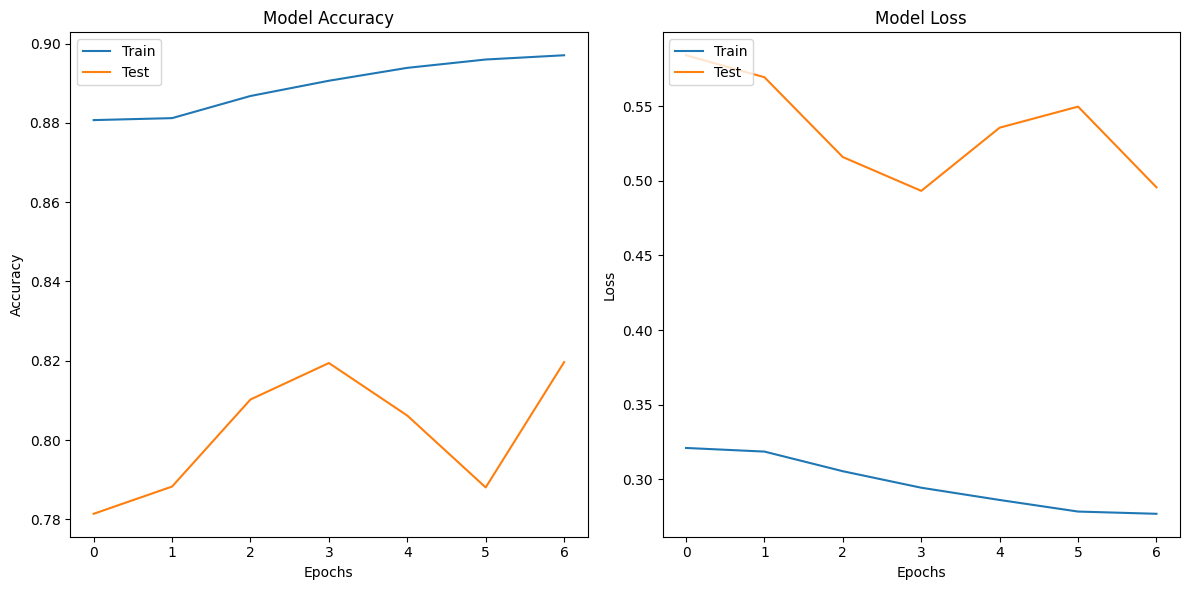

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


In [30]:
import numpy as np

def predict_sentiment_custom(user_input, vocabulary, model):
    cleaned_input = clean_text(user_input)
    input_sequence = texts_to_sequences([cleaned_input], vocabulary)
    padded_input = pad_sequences_custom(input_sequence, maxlen=100, padding='post')

    padded_input = np.array(padded_input)
    prediction = model.predict(padded_input)
    sentiment_class = np.argmax(prediction, axis=1)[0]
    
    sentiment_labels = ['Positive', 'Neutral', 'Negative', 'Irrelevant']
    
    return sentiment_labels[sentiment_class]

user_input = input("Enter a tweet to analyze its sentiment: ")
result = predict_sentiment_custom(user_input, vocabulary, model)
print(f"The sentiment of the tweet is: {result}")


Enter a tweet to analyze its sentiment:  what if i fail you in this product


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
The sentiment of the tweet is: Negative


In [31]:
# checking the model with validation .csv file

data_validation = pd.read_csv('twitter_validation.csv')
data_validation.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [32]:
data_validation.columns = ['id', 'company', 'Sentiment', 'Tweet']

In [33]:
tweets_val = data_validation['Tweet'].tolist()
sentiments_val = data_validation['Sentiment'].tolist()

In [37]:
cleaned_tweets = [clean_text(tweet) for tweet in tweets_val]
input_sequences = texts_to_sequences(cleaned_tweets, vocabulary)
padded_inputs = pad_sequences_custom(input_sequences, maxlen=100, padding='post')

padded_inputs = np.array(padded_inputs)

predictions = model.predict(padded_inputs)

predicted_classes = np.argmax(predictions, axis=1)

correct = 0
total = len(tweets_val)

for i in range(total):
    predicted_label = predicted_classes[i]
    true_label = sentiments_val[i]
    true_label = custom_mapping[sentiments_val[i]]
    if predicted_label == true_label:
        correct += 1

accuracy = (correct / total) * 100
print(f'The model predicted with accuracy of {accuracy:.2f}%')


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
The model predicted with accuracy of 93.19%


In [39]:
# Saving Model

model.save('sentiment_analyzer.keras')